In [333]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
y_train, y_test = y_train[:, 0], y_test[:, 0]

In [452]:
from skimage.transform import resize
(X_ood, _), _ = keras.datasets.mnist.load_data()

X_ood = X_ood[np.random.choice(range(len(X_ood)), int(len(X_ood) / 20))]

_X_ood = np.zeros((len(X_ood), 28, 28, 3))

for k in range(3):
    _X_ood[:, :, :, k] = X_ood

X_ood = np.array([resize(_X_ood[i], (32, 32)) for i in tqdm(range(len(X_ood)))])
'''
indices_of_ood_subclasses = np.where(y_train >= 2)[0]
X_ood = X_train[indices_of_ood_subclasses]
'''

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1002.91it/s]


'\nindices_of_ood_subclasses = np.where(y_train >= 2)[0]\nX_ood = X_train[indices_of_ood_subclasses]\n'

In [335]:

indices_of_subclasses = np.where(y_train < 2)[0]
X_train, y_train = X_train[indices_of_subclasses], y_train[indices_of_subclasses]

#random_indices = np.random.choice(range(len(y_test)), 1000, replace = False)
#X_train, y_train = X_train[random_indices], y_train[random_indices]
#random_indices = np.random.choice(range(len(y_test)), 500, replace = False)
#X_test, y_test = X_test[random_indices], y_test[random_indices]
indices_of_subclasses = np.where(y_test < 2)[0]
X_test, y_test = X_test[indices_of_subclasses], y_test[indices_of_subclasses]

In [514]:
#load and train model 
inp = keras.layers.Input(np.shape(X_train)[1:])

x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inp)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)


x = keras.layers.Dense(units=1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
enc = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
cls_logits = keras.layers.Dense(units=len(np.unique(y_train)), activation = 'linear')(enc)
cls_out = keras.layers.Activation('softmax', name = 'cls_out')(cls_logits)

network = keras.models.Model(inputs = inp, outputs = cls_out)
encoder = keras.models.Model(inputs = inp, outputs = enc)
network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-4),
          metrics = ['acc'])
network.fit(X_train, keras.utils.to_categorical(y_train), 
    epochs = 15,
    verbose = 1,
    validation_split = .1)

Epoch 1/15
282/282 [==============================] - 3s 7ms/step - loss: 0.4309 - acc: 0.8320 - val_loss: 0.3474 - val_acc: 0.8640
Epoch 2/15
282/282 [==============================] - 2s 6ms/step - loss: 0.2632 - acc: 0.8937 - val_loss: 0.2605 - val_acc: 0.8990
Epoch 3/15
282/282 [==============================] - 2s 6ms/step - loss: 0.2015 - acc: 0.9204 - val_loss: 0.1655 - val_acc: 0.9360
Epoch 4/15
282/282 [==============================] - 2s 6ms/step - loss: 0.1602 - acc: 0.9387 - val_loss: 0.1671 - val_acc: 0.9440
Epoch 5/15
282/282 [==============================] - 2s 6ms/step - loss: 0.1453 - acc: 0.9440 - val_loss: 0.1509 - val_acc: 0.9460
Epoch 6/15
282/282 [==============================] - 2s 6ms/step - loss: 0.1177 - acc: 0.9541 - val_loss: 0.1802 - val_acc: 0.9410
Epoch 7/15
282/282 [==============================] - 2s 6ms/step - loss: 0.0987 - acc: 0.9620 - val_loss: 0.1861 - val_acc: 0.9350
Epoch 8/15
282/282 [==============================] - 2s 6ms/step - loss: 0.

In [515]:
encoding_X_train = encoder.predict(X_train).reshape(X_train.shape[0], -1)
encoding_X_test = encoder.predict(X_test).reshape(X_test.shape[0], -1)

In [516]:
encoding_X_ood = encoder.predict(X_ood).reshape(X_ood.shape[0], -1)

In [579]:
class_means, class_lower_percentile, class_upper_percentile = [], [], []
for c in range(len(np.unique(y_train))):
    examples_of_class = np.where(y_train == c)[0]
    class_means.append(np.mean(encoding_X_train[examples_of_class], axis = 0))
    class_lower_percentile.append(np.percentile(np.sqrt(np.sum(encoding_X_train[examples_of_class] ** 2, axis = 1)), 75))
    class_upper_percentile.append(np.percentile(np.sqrt(np.sum(encoding_X_train[examples_of_class] ** 2, axis = 1)), 100))

In [580]:
from scipy.stats import multivariate_normal as mv
vos_samples = []
for c in tqdm(range(len(np.unique(y_train)))):
    examples_of_class = np.where(y_train == c)[0]
    vos_samples_of_class = mv.rvs(mean = 0, cov = 1, size = (int(len(examples_of_class) / 3), np.shape(encoding_X_train)[1]))
    vos_samples_of_class = vos_samples_of_class / np.linalg.norm(vos_samples_of_class, axis =1)[:, np.newaxis]
    magnitudes = np.random.uniform(class_lower_percentile[c], class_upper_percentile[c], size = len(vos_samples_of_class))
    vos_samples_of_class = class_means[c] + vos_samples_of_class * magnitudes[:, np.newaxis]
    vos_samples.extend(vos_samples_of_class)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.38it/s]


In [581]:
ood_X_train = np.concatenate([encoding_X_train, vos_samples], axis = 0)
ood_y_train = np.concatenate([keras.utils.to_categorical(y_train), np.ones((len(vos_samples), len(np.unique(y_train)))) / len(np.unique(y_train))])

In [582]:
import tensorflow as tf
x = keras.layers.Dense(100, activation = 'relu')(enc)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
pre_temperature = keras.layers.Dense(units = 1, activation = 'linear')(x)
#temperature = keras.layers.Lambda(lambda v : keras.activations.sigmoid(v) * 10)(pre_temperature)
#custom loss. We want the temperature to be unbounded on the positive side (and therefore when the pretemperature is greater than 0, it's unbounded; 
#but we also need to make sure the temperature is never negative - so we don't get infinite logits. So we do an exponentially decaying activation on the negative side)
temperature = keras.layers.Activation(lambda v : tf.where(v < 0, keras.activations.exponential(v), 1 + keras.activations.linear(v)))(pre_temperature)
ood_cls_logits = keras.layers.Lambda(lambda inputs: inputs[0] / inputs[1])([cls_logits, temperature])
ood_cls_out = keras.layers.Activation('softmax')(ood_cls_logits)

temperature_model = keras.models.Model(inputs = enc, outputs = temperature)
ood_network = keras.models.Model(inputs = enc, outputs = ood_cls_out)
for layer in network.layers:
    layer.trainable = False
ood_network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-2))
ood_network.fit(ood_X_train, ood_y_train, 
    epochs = 15,
    verbose = 1,
    validation_split = .1)

Epoch 1/15
375/375 [==============================] - 3s 5ms/step - loss: 166.1800 - val_loss: 2.9495
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4473 - val_loss: 2.8184
Epoch 3/15
375/375 [==============================] - 2s 4ms/step - loss: 0.3981 - val_loss: 2.6015
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3717 - val_loss: 2.4808
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3498 - val_loss: 2.1193
Epoch 6/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3339 - val_loss: 2.0803
Epoch 7/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3297 - val_loss: 2.1344
Epoch 8/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3066 - val_loss: 1.9016
Epoch 9/15
375/375 [==============================] - 2s 5ms/step - loss: 0.2987 - val_loss: 1.8853
Epoch 10/15
375/375 [==============================] - 2s 5ms/step - loss: 0.2823 - val_loss: 1.78

In [654]:
from copy import deepcopy
import tensorflow as tf
encoding_X_ood_grad = deepcopy(encoding_X_ood)
tensor = tf.convert_to_tensor(encoding_X_ood_grad, dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(tensor)
    pred = ood_network(tensor)
    y = [-pred[i, keras.backend.argmax(pred[i])] for i in range(len(pred))]
dy_dx = tape.gradient(y, tensor)
encoding_X_ood_grad -= dy_dx

encoding_X_train_grad = deepcopy(encoding_X_train)
tensor = tf.convert_to_tensor(encoding_X_train_grad, dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(tensor)
    pred = ood_network(tensor)
    y = [-pred[i, keras.backend.argmax(pred[i])] for i in range(len(pred))]
dy_dx = tape.gradient(y, tensor)
encoding_X_train_grad -= dy_dx

In [655]:
t = temperature_model.predict(encoding_X_train)
print("In Distribution Temperature: ", np.mean(t))

In Distribution Temperature:  2.366917


In [656]:
t = temperature_model.predict(encoding_X_train_grad)
print("In Distribution Grad Temperature: ", np.mean(t))

In Distribution Grad Temperature:  2.3586535


In [657]:
t = temperature_model.predict(np.array(vos_samples))
print("VO Temperature (we want this to be much higher than the in distribution temperature): ", np.mean(t))

VO Temperature (we want this to be much higher than the in distribution temperature):  7.5467553


In [658]:
t = temperature_model.predict(encoding_X_ood)
print("OOD Temperature (we want this to be much higher than the in distribution temperature): ", np.mean(t))

OOD Temperature (we want this to be much higher than the in distribution temperature):  10.414315


In [659]:
t = temperature_model.predict(encoding_X_ood_grad)
print("OOD Grad Temperature (we want this to be much higher than the in distribution temperature): ", np.mean(t))

OOD Grad Temperature (we want this to be much higher than the in distribution temperature):  10.406044


In [660]:
vos_pred = ood_network.predict(np.array(vos_samples))
print("Temperature Deflated VO Confidence Average (we want this to be really low): ", np.mean(np.max(vos_pred, axis = 1)))

Temperature Deflated VO Confidence Average (we want this to be really low):  0.83224255


In [661]:
ood_pred = ood_network.predict(encoding_X_ood)
print("Temperature Deflated OOD Confidence Average (we want this to be really low): ", np.mean(np.max(ood_pred, axis = 1)))

Temperature Deflated OOD Confidence Average (we want this to be really low):  0.7016384


In [662]:
ood_grad_pred = ood_network.predict(encoding_X_ood_grad)
print("Temperature Deflated OOD Grad Confidence Average (we want this to be really low): ", np.mean(np.max(ood_grad_pred, axis = 1)))

Temperature Deflated OOD Grad Confidence Average (we want this to be really low):  0.7036039


In [663]:
id_pred = ood_network.predict(encoding_X_train)
print("Temperature Deflated In-Distribution Confidence Average: ", np.mean(np.max(id_pred, axis = 1)))

Temperature Deflated In-Distribution Confidence Average:  0.96994084


In [664]:
id_grad_pred = ood_network.predict(encoding_X_train_grad)
print("Temperature Deflated In-Distribution Grad Confidence Average: ", np.mean(np.max(id_grad_pred, axis = 1)))

Temperature Deflated In-Distribution Grad Confidence Average:  0.97295856


In [667]:
from sklearn.metrics import roc_auc_score
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred))), np.zeros((len(ood_pred)))]), np.concatenate([np.max(id_pred, axis = 1), np.max(ood_pred, axis = 1)])))
print("Grad AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_grad_pred))), np.zeros((len(ood_grad_pred)))]), np.concatenate([np.max(id_grad_pred, axis = 1), np.max(ood_grad_pred, axis = 1)])))

AUC:  0.9763833333333333
Grad AUC:  0.9817306333333332


In [668]:
vo_pred = keras.models.Model(inputs = enc, outputs = cls_out).predict(np.array(vos_samples))
print("Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(vo_pred, axis = 1)))

Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD):  0.977785


In [669]:
ood_pred = keras.models.Model(inputs = enc, outputs = cls_out).predict(encoding_X_ood)
print("Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(ood_pred, axis = 1)))

Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD):  0.94881797


In [671]:
ood_grad_pred = keras.models.Model(inputs = enc, outputs = cls_out).predict(encoding_X_ood_grad)
print("Unaffected Model OOD Grad Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(ood_grad_pred, axis = 1)))

Unaffected Model OOD Grad Confidence Average (this being high shows networks are overconfident OOD):  0.9524294


In [674]:
id_pred = network.predict(X_train)
print("Unaffected Model In-Distribution Confidence Average: ", np.mean(np.max(id_pred, axis = 1)))

Unaffected Model In-Distribution Confidence Average:  0.9902293


In [675]:
id_grad_pred = network.predict(X_train)
print("Unaffected Model In-Distribution Grad Confidence Average: ", np.mean(np.max(id_grad_pred, axis = 1)))

Unaffected Model In-Distribution Grad Confidence Average:  0.9902293


In [676]:
from sklearn.metrics import roc_auc_score
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred))), np.zeros((len(ood_pred)))]), np.concatenate([np.max(id_pred, axis = 1), np.max(ood_pred, axis = 1)])))
print("Grad AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_grad_pred))), np.zeros((len(ood_grad_pred)))]), np.concatenate([np.max(id_grad_pred, axis = 1), np.max(ood_grad_pred, axis = 1)])))

AUC:  0.6046514833333334
Grad AUC:  0.60194295


In [283]:
def get_ece(confidences, correctness):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 100
    for i in range(num_bins):
        prop = i*1./num_bins
        inds = np.where((confidences >= prop) & (confidences <= prop+1./num_bins))[0]
        amts.append(len(inds))
        if len(inds) > 0:
            hists.append(len(np.where(correctness[inds] == 1)[0])*1./len(inds))
            hists_hat.append(np.mean(confidences[inds]))
        else:
            hists.append(prop)
            hists_hat.append(prop + 0.5/num_bins)
    return np.sum(np.abs(np.array(hists) - np.array(hists_hat)) * np.array(amts)) / np.sum(amts)

In [284]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred = network.predict(X_test)

print(roc_auc_score(np.argmax(pred, axis = 1) == y_test, np.max(pred, axis = 1)))
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.8739016309789354


0.059906843707809465

In [285]:
pred = ood_network.predict(encoding_X_test)
print(roc_auc_score(np.argmax(pred, axis = 1) == y_test, np.max(pred, axis = 1)))
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.8143316620212697


0.06499555899842381

In [286]:
ood_scores_test = temperature_model.predict(encoding_X_test)[:, 0]

In [287]:
model_predictions = network.predict(X_test)
ood_model_predictions = ood_network.predict(encoding_X_test)

In [288]:
num_intervals = 20

In [321]:
#z_scores = p_label_error / (variance_confidences + 1e-12)
from sklearn.metrics import average_precision_score
order = np.argsort(ood_scores_test)
ps = []
accs = []
base_eces = []
ood_model_eces = []
base_confidences = []
ood_model_confidences = []
model_acc = []
ood_model_acc = []

for i in range(0, len(y_test), int(len(y_test) / num_intervals)):
    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(np.mean(model_predictions[order[i:i + int(len(y_test) / num_intervals)], j]))#get_ece(np.array(model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    base_eces.append(np.mean(class_eces))
    base_confidences.append(np.mean(np.max(model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1)))
    model_acc.append(np.mean(np.argmax(model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == y_test[order[i:i + int(len(y_test) / num_intervals)]]))

    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(np.mean(np.array(ood_model_predictions)[order[:i + int(len(y_test) / num_intervals)], j]))#get_ece(np.array(ood_model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    ood_model_eces.append(np.median(class_eces))
    ood_model_confidences.append(np.mean(np.max(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1)))
    ood_model_acc.append(np.mean(np.argmax(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == y_test[order[i:i + int(len(y_test) / num_intervals)]]))

In [322]:
ood_model_confidences

[1.0,
 1.0,
 0.9964615,
 0.99706507,
 0.99210966,
 0.9998701,
 0.9988194,
 0.99262315,
 0.9836587,
 0.9903807,
 0.9800699,
 0.98944277,
 0.9825737,
 0.98193717,
 0.95985913,
 0.95834273,
 0.95657325,
 0.9341005,
 0.93240553,
 0.883628]

In [332]:
ood_model_acc

[0.98,
 0.98,
 0.95,
 0.97,
 0.99,
 0.96,
 0.95,
 0.93,
 0.92,
 0.9,
 0.89,
 0.92,
 0.89,
 0.96,
 0.82,
 0.9,
 0.93,
 0.92,
 0.96,
 0.89]

In [331]:
np.mean(np.abs(np.array(ood_model_acc) - np.array(ood_model_confidences)))

0.048392693519592286

In [329]:
np.mean(np.abs(np.array(model_acc) - np.array(base_confidences)))

0.03807096266746521

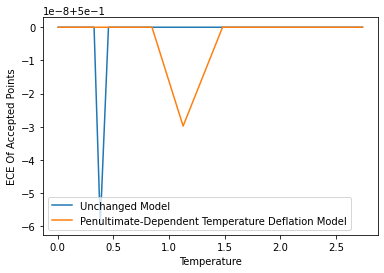

In [299]:
import matplotlib.pyplot as plt
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], base_eces, label = "Unchanged Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), base_eces, label = "Unchanged Model")
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
plt.xlabel("Temperature")
plt.ylabel("ECE Of Accepted Points")
plt.legend()

The blue line increasing shows that when temperature is high, ECE is high -> we can detect when we're miscalibrated (when we're OOD) and we know it by a high temperature. On this, we deflate confidence.